In [1]:
import pandas as pd
import json
import pandas as pd
from cobra import Model, Reaction, Metabolite
import pickle
from tqdm import tqdm 
from ast import literal_eval
import cobra
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

### input and output

In [2]:
### input
yeast870_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_path = '../../Data/model/yeast8U_del2_re.yml'
PNAs_biology_filepath = '../../Data/pnas.1406102111.sd02.xlsx'

### output
figure_6a_path = '../../Results/Figures/fig6-a.pdf'


### growth phenotype

In [3]:
def get_yeast8id_by_biggid(biggid,model):
    biggid = biggid.replace('(e)','').replace('EX_','')
    yeast8_id = ''
    for i in model.metabolites:
        try:
            if i.annotation['bigg.metabolite'] == biggid:
                yeast8_id = i.id
                break
        except:pass
    return yeast8_id

In [4]:
def prepra_biolog_data(PNAs_biology_filepath,yeast870_path):
    yeast8 = cobra.io.load_yaml_model(yeast870_path)
    PNAs_biology = pd.read_excel(PNAs_biology_filepath,sheet_name='Exchange_reactions')
    PNAs_biology['Carbon'] = PNAs_biology['Carbon'].apply(lambda x:x.replace('_D(e)','__D(e)').replace('_L(e)','__L(e)').replace('EX_glc(e)','EX_glc__D(e)'))
    PNAs_biology['Carbon_id'] = PNAs_biology['Carbon'].apply(lambda x:get_yeast8id_by_biggid(x,yeast8))
    PNAs_biology['Nitrogen_id'] = PNAs_biology['Nitrogen'].apply(lambda x:get_yeast8id_by_biggid(x,yeast8))
    PNAs_biology['Phosphorus_id'] = PNAs_biology['Phosphorus'].apply(lambda x:get_yeast8id_by_biggid(x,yeast8))
    PNAs_biology['Sulfur_id'] = PNAs_biology['Sulfur'].apply(lambda x:get_yeast8id_by_biggid(x,yeast8))  
    # print(len(PNAs_biology[PNAs_biology['Carbon_id']=='']['Carbon'].value_counts().index.to_list()))
    # print(len(PNAs_biology[PNAs_biology['Nitrogen_id']=='']['Nitrogen'].value_counts().index.to_list()))
    # print(len(PNAs_biology[PNAs_biology['Phosphorus_id']=='']['Phosphorus'].value_counts().index.to_list()))
    # print(len(PNAs_biology[PNAs_biology['Sulfur_id']=='']['Sulfur'].value_counts().index.to_list()))
    PNAs_biology = PNAs_biology[PNAs_biology['Carbon_id']!='']
    PNAs_biology = PNAs_biology[PNAs_biology['Nitrogen_id']!='']
    PNAs_biology = PNAs_biology[PNAs_biology['Phosphorus_id']!='']
    PNAs_biology = PNAs_biology[PNAs_biology['Sulfur_id']!='']
    print(PNAs_biology.shape)
    PNAs_biology.reset_index(inplace=True,drop=True)
    return PNAs_biology

In [5]:
PNAs_biology = prepra_biolog_data(PNAs_biology_filepath,yeast870_path)

(1490, 11)


In [6]:
PNAs_biology.head()

,Carbon,Nitrogen,Phosphorus,Sulfur,Aerobic,In silico biomass flux of native model,In silico biomass flux of native model extended with all underground reactions,Carbon_id,Nitrogen_id,Phosphorus_id,Sulfur_id
0,EX_glc__D(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,3.693414,3.724248,s_0563,s_0419,s_1322,s_1467
1,EX_15dap(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,0.000000,0.000000,s_4299,s_0419,s_1322,s_1467
2,EX_23camp(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,4.512330,4.524823,s_0131,s_0419,s_1322,s_1467
3,EX_23ccmp(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,4.610391,4.648776,s_4126,s_0419,s_1322,s_1467
4,EX_23cgmp(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,4.530541,4.530599,s_4094,s_0419,s_1322,s_1467


In [7]:
def get_all_compartment_metid(Target_met,model):
    all_compartment_metid = []
    tmp_name = model.metabolites.get_by_id(Target_met).name
    for met in model.metabolites:
        if met.name == tmp_name:
            all_compartment_metid.append(met.id)
    return(all_compartment_metid)

# Target_met = 's_0419'
# model = yeast8
# get_all_compartment_metid(Target_met,model)

In [8]:
def get_exchange_reaction(Target_met,model):
    if Target_met!='':
        exchange_reaction = ''
        for i in model.reactions:
            if Target_met in i.reaction and len(i.metabolites) == 1:
                exchange_reaction = i.id 
        return exchange_reaction
    else:
        return('')

In [11]:
def calculate_biology_biomass(Carbon_id,Nitrogen_id,Phosphorus_id,Sulfur_id,Aerobic,model):
    model.reactions.get_by_id('r_1714').bounds = (0,0)#C
    model.reactions.get_by_id('r_1654').bounds = (0,0)#N
    model.reactions.get_by_id('r_2005').bounds = (0,0)#P
    model.reactions.get_by_id('r_2060').bounds = (0,0)#S
    model.reactions.get_by_id('r_1992').bounds = (0,0)#O

    #Carbon_id
    Carbon_id_list = get_all_compartment_metid(Carbon_id,model)
    for each_Carbon_id in Carbon_id_list:
        if model.metabolites.get_by_id(each_Carbon_id).compartment == 'e':
            exchange_reaction_C = get_exchange_reaction(each_Carbon_id,model)
            if exchange_reaction_C!='':
                model.reactions.get_by_id(exchange_reaction_C).bounds=(-1,1000)
    #Nitrogen_id
    Nitrogen_id_list = get_all_compartment_metid(Nitrogen_id,model)
    for each_Nitrogen_id in Nitrogen_id_list:
        if model.metabolites.get_by_id(each_Nitrogen_id).compartment == 'e':
            exchange_reaction_N = get_exchange_reaction(each_Nitrogen_id,model)
            if exchange_reaction_N!='':
                model.reactions.get_by_id(exchange_reaction_N).bounds=(-1,1000)   
    #Phosphorus_id
    Phosphorus_id_list = get_all_compartment_metid(Phosphorus_id,model)
    for each_Phosphorus_id in Phosphorus_id_list:
        if model.metabolites.get_by_id(each_Phosphorus_id).compartment == 'e':
            exchange_reaction_P = get_exchange_reaction(each_Phosphorus_id,model)
            if exchange_reaction_P!='':
                model.reactions.get_by_id(exchange_reaction_P).bounds=(-1,1000)                  
    #Sulfur_id
    Sulfur_id_list = get_all_compartment_metid(Sulfur_id,model)
    for each_Sulfur_id in Sulfur_id_list:
        if model.metabolites.get_by_id(each_Sulfur_id).compartment == 'e':
            exchange_reaction_S = get_exchange_reaction(each_Sulfur_id,model)
            if exchange_reaction_S!='':
                model.reactions.get_by_id(exchange_reaction_S).bounds=(-1,1000) 
    #Aerobic
    if Aerobic == 'Yes':
        model.reactions.get_by_id('r_1992').bounds=(-1000,1000) 

    solution = model.optimize()
    
    try:
        model.reactions.get_by_id(exchange_reaction_C).bounds = (0,0)
    except:pass
    try:
        model.reactions.get_by_id(exchange_reaction_N).bounds = (0,0)
    except:pass
    try:
        model.reactions.get_by_id(exchange_reaction_P).bounds = (0,0)
    except:pass
    try:
        model.reactions.get_by_id(exchange_reaction_S).bounds = (0,0)
    except:pass

    if model.reactions.get_by_id('r_2111').flux >0.001:
        biomass = model.reactions.get_by_id('r_2111').flux
    else:
        biomass = 0
  
    # if solution.fluxes['r_2111'] > 0.001:
    #     biomass = solution.fluxes['r_2111']
    # else:
    #     biomass = 0

    return biomass


In [ ]:
yeast8 = cobra.io.load_yaml_model(yeast870_path)
if yeast8.reactions.get_by_id('r_2111').flux >0.001:
    biomass = yeast8.reactions.get_by_id('r_2111').flux
biomass


In [ ]:

yeast_biomass = []
for index,row in tqdm(PNAs_biology.iterrows(),total=len(PNAs_biology)):
    yeast_biomass.append(calculate_biology_biomass(row['Carbon_id'],row['Nitrogen_id'],row['Phosphorus_id'],row['Sulfur_id'],row['Aerobic'], yeast8))
PNAs_biology['yeast_biomass'] = yeast_biomass

In [ ]:
yeast8U = cobra.io.load_yaml_model(yeast8U_path)

yeast_plus_biomass = []
for index,row in tqdm(PNAs_biology.iterrows(),total=len(PNAs_biology)):
    yeast_plus_biomass.append(calculate_biology_biomass(row['Carbon_id'],row['Nitrogen_id'],row['Phosphorus_id'],row['Sulfur_id'],row['Aerobic'], yeast8U))
PNAs_biology['yeast_U_biomass'] = yeast_plus_biomass

In [11]:
PNAs_biology[PNAs_biology['Carbon']=='EX_lys__L(e)']

,Carbon,Nitrogen,Phosphorus,Sulfur,Aerobic,In silico biomass flux of native model,In silico biomass flux of native model extended with all underground reactions,Carbon_id,Nitrogen_id,Phosphorus_id,Sulfur_id,yeast_biomass,yeast_U_biomass
106,EX_lys__L(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,0.0,0.0,s_1025,s_0419,s_1322,s_1467,0.0,0.0
851,EX_lys__L(e),EX_nh4(e),EX_pi(e),EX_so4(e),No,0.0,0.0,s_1025,s_0419,s_1322,s_1467,0.0,0.0


In [12]:
print(len(PNAs_biology[PNAs_biology['yeast_biomass']!=0]))
print(len(PNAs_biology[PNAs_biology['yeast_U_biomass']!=0]))
len(PNAs_biology)

60
236


1490

In [13]:
PNAs_biology[(PNAs_biology['yeast_U_biomass']!=0)&(PNAs_biology['yeast_biomass']==0)&(PNAs_biology['Sulfur']=='EX_so4(e)')&(PNAs_biology['Phosphorus']=='EX_pi(e)')&(PNAs_biology['Nitrogen']=='EX_nh4(e)')]

,Carbon,Nitrogen,Phosphorus,Sulfur,Aerobic,In silico biomass flux of native model,In silico biomass flux of native model extended with all underground reactions,Carbon_id,Nitrogen_id,Phosphorus_id,Sulfur_id,yeast_biomass,yeast_U_biomass
39,EX_cys__L(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,0.638823,0.744391,s_0981,s_0419,s_1322,s_1467,0.0,0.015985
77,EX_gly(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,0.863653,0.876940,s_1003,s_0419,s_1322,s_1467,0.0,0.003825
95,EX_hom__L(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,0.000000,0.000000,s_1014,s_0419,s_1322,s_1467,0.0,0.016377
101,EX_ins(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,4.215684,4.227316,s_0856,s_0419,s_1322,s_1467,0.0,0.060758
103,EX_lac__D(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,1.054546,1.062595,s_0025,s_0419,s_1322,s_1467,0.0,0.019222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,EX_xyl__D(e),EX_nh4(e),EX_pi(e),EX_so4(e),No,2.086058,2.105290,s_0578,s_0419,s_1322,s_1467,0.0,0.047095
928,EX_amet,EX_nh4(e),EX_pi(e),EX_so4(e),No,0.000000,0.000000,s_1416,s_0419,s_1322,s_1467,0.0,0.037920
937,EX_gcald,EX_nh4(e),EX_pi(e),EX_so4(e),No,0.000000,0.000000,s_0775,s_0419,s_1322,s_1467,0.0,0.004134
948,EX_pydxn,EX_nh4(e),EX_pi(e),EX_so4(e),No,0.000000,0.000000,s_1396,s_0419,s_1322,s_1467,0.0,0.097806


## The median of the lifted value

In [14]:
tmp = PNAs_biology[PNAs_biology['yeast_biomass']!=0]
tmp['ratio'] = PNAs_biology['yeast_U_biomass']/PNAs_biology['yeast_biomass']
tmp['add'] = PNAs_biology['yeast_U_biomass']-PNAs_biology['yeast_biomass']
print(tmp['ratio'].median())
print(tmp['add'].median())
tmp

1.24827373447223
0.010538927894508436


,Carbon,Nitrogen,Phosphorus,Sulfur,Aerobic,In silico biomass flux of native model,In silico biomass flux of native model extended with all underground reactions,Carbon_id,Nitrogen_id,Phosphorus_id,Sulfur_id,yeast_biomass,yeast_U_biomass,ratio,add
0,EX_glc__D(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,3.693414,3.724248,s_0563,s_0419,s_1322,s_1467,0.081928,0.087550,1.068614,0.005621
2,EX_23camp(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,4.512330,4.524823,s_0131,s_0419,s_1322,s_1467,0.073717,0.089084,1.208461,0.015367
4,EX_23cgmp(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,4.530541,4.530599,s_4094,s_0419,s_1322,s_1467,0.072779,0.082911,1.139217,0.010132
6,EX_3amp(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,4.512330,4.524823,s_4106,s_0419,s_1322,s_1467,0.073717,0.089084,1.208461,0.015367
7,EX_3gmp(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,4.530541,4.530599,s_4068,s_0419,s_1322,s_1467,0.072779,0.082911,1.139216,0.010132
9,EX_4abut(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,0.584076,0.588547,s_0734,s_0419,s_1322,s_1467,0.054899,0.059616,1.085925,0.004717
10,EX_5dglcn(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,3.309318,3.337363,s_4117,s_0419,s_1322,s_1467,0.067757,0.072406,1.068614,0.004649
11,EX_ac(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,0.397689,0.401771,s_0362,s_0419,s_1322,s_1467,0.015547,0.018729,1.204675,0.003182
12,EX_acac(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,1.295148,1.308409,s_4132,s_0419,s_1322,s_1467,0.041046,0.046444,1.131506,0.005398
13,EX_acald(e),EX_nh4(e),EX_pi(e),EX_so4(e),Yes,1.062497,1.070148,s_0359,s_0419,s_1322,s_1467,0.022679,0.026068,1.149428,0.003389


In [15]:
data = [PNAs_biology['yeast_biomass'], PNAs_biology['yeast_U_biomass']]
data

[0       0.081928
 1       0.000000
 2       0.073717
 3       0.000000
 4       0.072779
           ...   
 1485    0.000000
 1486    0.000000
 1487    0.000000
 1488    0.000000
 1489    0.000000
 Name: yeast_biomass, Length: 1490, dtype: float64,
 0       0.087550
 1       0.000000
 2       0.089084
 3       0.000000
 4       0.082911
           ...   
 1485    0.000000
 1486    0.000000
 1487    0.000000
 1488    0.000000
 1489    0.000000
 Name: yeast_U_biomass, Length: 1490, dtype: float64]

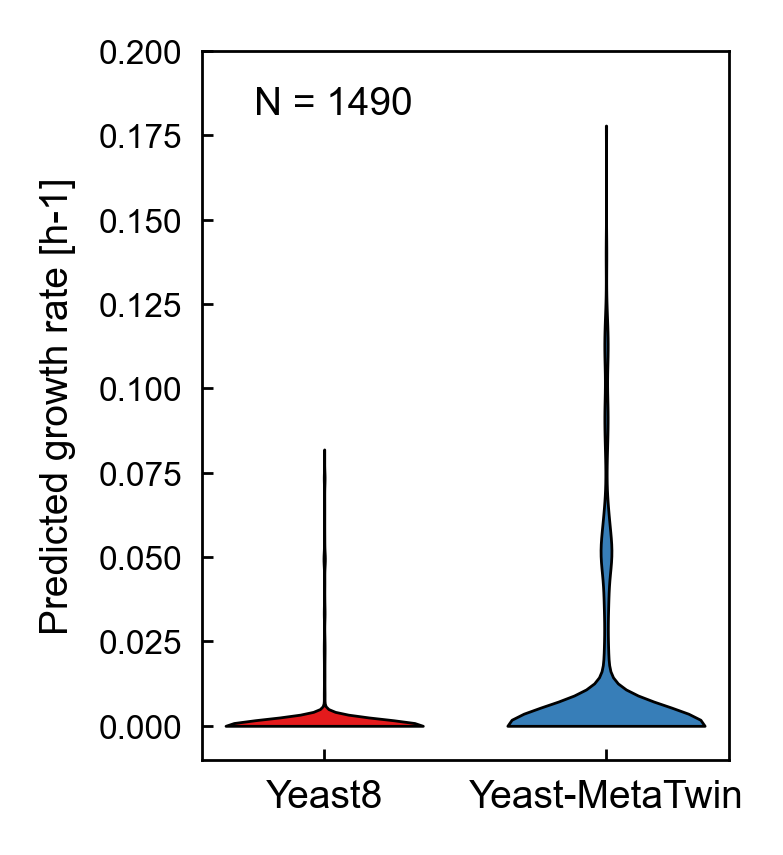

In [18]:


# Select relevant columns from the dataframe
df = PNAs_biology[['yeast_biomass', 'yeast_U_biomass']]
labels = ['Yeast8', 'Yeast-MetaTwin']

# Set general parameters
plt.figure(figsize=(1.7, 2.3), dpi=400)
plt.rcParams.update({'font.size': 6})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Set axis styles
plt.xticks(fontsize=7)
plt.yticks(fontsize=6)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.grid(False)

# Force display of y-axis ticks
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

# Create violin plot
vp = plt.violinplot(dataset=[df['yeast_biomass'], df['yeast_U_biomass']],
                    positions=np.arange(len(labels)), showmedians=False, widths=0.7,
                    vert=True, showextrema=False, showmeans=False)

# Set colors for the violins
colors = ['#e41a1c', '#377eb8']
for i, pc in enumerate(vp['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_linewidth(0.5)
    pc.set_alpha(1)

# Set x-axis labels
plt.xticks(np.arange(len(labels)), labels)

# Set axis parameters
plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)
plt.ylim(-0.01, 0.2)
plt.ylabel('Predicted growth rate [h-1]', fontsize=7)

# Add text annotation
plt.text(0.1, 0.95, 'N = 1490', ha='left', va='top', transform=plt.gca().transAxes, fontsize=7, family='Arial')

# Save the figure
plt.savefig(figure_6a_path, dpi=400, bbox_inches='tight')

# Display the figure
plt.show()